In [1]:
# convertion of .prn to .csv of all prn files in folder along with deleting 2-16 rows since observed as junk

import struct
import pandas as pd
import os
from pathlib import Path

def binary_to_csv(input_file, output_file):
    """
    Convert a single PRN file to CSV format
    """
    data = []
    try:
        with open(input_file, 'rb') as file:
            while chunk := file.read(8):  # 8 bytes for two floats
                try:
                    frequency, spectrum = struct.unpack('ff', chunk)
                    data.append({"column1": frequency, "column2": spectrum})
                except struct.error:
                    break
                    
        df = pd.DataFrame(data)
        df.to_csv(output_file, index=False)
        return True
    except Exception as e:
        print(f"Error processing {input_file}: {str(e)}")
        return False

def process_all_prn_files(input_folder, output_folder):
    """
    Process all PRN files in the input folder and save CSVs to output folder
    """
    # Create output folder if it doesn't exist
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    
    # Get list of all PRN files
    prn_files = [f for f in os.listdir(input_folder) if f.lower().endswith('.prn')]
    
    if not prn_files:
        print(f"No PRN files found in {input_folder}")
        return
    
    # Process each file
    successful = 0
    failed = 0
    
    for prn_file in prn_files:
        input_path = os.path.join(input_folder, prn_file)
        output_path = os.path.join(output_folder, f"{os.path.splitext(prn_file)[0]}.csv")
        
        print(f"Processing: {prn_file}")
        if binary_to_csv(input_path, output_path):
            # Remove the first 16 rows (excluding header) from the CSV
            df = pd.read_csv(output_path)
            df = df.iloc[16:]  # Keep rows from index 16 onwards
            df.to_csv(output_path, index=False)  # Save the modified DataFrame
            successful += 1
        else:
            failed += 1
    
    # Print summary
    print("\nConversion Summary:")
    print(f"Total files processed: {len(prn_files)}")
    print(f"Successfully converted: {successful}")
    print(f"Failed conversions: {failed}")

# Example usage
input_folder = r"D:\sprint(main)\wave .prn\OneDrive_1_12-30-2024"
output_folder = r"D:\sprint(main)\python file convertor\convertion\output2"

process_all_prn_files(input_folder, output_folder)

Processing: calib_irr_001.prn
Processing: calib_irr_002.prn
Processing: calib_irr_003.prn
Processing: calib_irr_004.prn
Processing: calib_irr_005.prn
Processing: calib_irr_006.prn
Processing: calib_irr_007.prn
Processing: calib_irr_008.prn
Processing: calib_irr_009.prn
Processing: calib_irr_010.prn
Processing: calib_irr_011.prn
Processing: calib_irr_012.prn
Processing: calib_irr_013.prn
Processing: calib_irr_014.prn
Processing: calib_irr_015.prn
Processing: calib_irr_016.prn
Processing: calib_irr_017.prn
Processing: calib_irr_018.prn
Processing: calib_irr_019.prn
Processing: calib_irr_020.prn
Processing: calib_irr_021.prn
Processing: calib_irr_022.prn
Processing: calib_irr_023.prn
Processing: calib_irr_024.prn
Processing: calib_irr_025.prn
Processing: calib_irr_026.prn
Processing: calib_irr_027.prn
Processing: calib_irr_028.prn
Processing: calib_irr_029.prn
Processing: calib_irr_030.prn
Processing: calib_irr_031.prn
Processing: calib_irr_032.prn

Conversion Summary:
Total files process

In [14]:
#plotting line graph of all .csv file

import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_and_save_data(input_file, column_name, output_folder):
    # Read the CSV file
    df = pd.read_csv(input_file)

    # Check if the specified column exists
    if column_name not in df.columns:
        print(f"Column '{column_name}' does not exist in the CSV file: {input_file}.")
        return

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Plotting the line chart
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[column_name], label=column_name, color='blue')
    plt.title(f'Line Chart of {column_name} from {os.path.basename(input_file)}')
    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.legend()
    plt.grid()

    # Save the plot
    output_file_path = os.path.join(output_folder, f'{os.path.basename(input_file).replace(".csv", "")}_line_chart.png')
    plt.savefig(output_file_path)
    plt.close()  # Close the plot to free memory
    print(f"Line chart saved to {output_file_path}")

# Main function to process all CSV files in the specified directory
def process_all_csv_files(input_folder, column_name, output_folder):
    # Get list of all CSV files in the input folder
    csv_files = [f for f in os.listdir(input_folder) if f.lower().endswith('.csv')]
    
    if not csv_files:
        print(f"No CSV files found in {input_folder}.")
        return

    # Process each CSV file
    for csv_file in csv_files:
        input_file_path = os.path.join(input_folder, csv_file)
        plot_and_save_data(input_file_path, column_name, output_folder)

# Example usage
input_folder = r"D:\sprint(main)\python file convertor\convertion\new"  # Path to the CSVs directory
output_folder = r"D:\sprint(main)\python file convertor\convertion\plot4"  # Path to the output directory for plots
column_name = 'Spectrum'  # Replace with the actual column name you want to plot

process_all_csv_files(input_folder, column_name, output_folder)

Line chart saved to D:\sprint(main)\python file convertor\convertion\plot4\Waves_001_line_chart.png


In [15]:
# checks how many rows and column present in .prn file

import struct
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from typing import Tuple, List, Dict

def detect_file_structure(input_file: str) -> Tuple[int, int]:
    """
    Detect the number of columns in a PRN file by analyzing its structure
    Returns: (number_of_columns, number_of_rows)
    """
    file_size = os.path.getsize(input_file)
    float_size = 4  # size of float in bytes
    max_cols_to_try = 8  # Try up to 8 columns
    
    with open(input_file, 'rb') as file:
        # Read a larger chunk for better analysis
        sample_data = file.read(float_size * max_cols_to_try * 2)
        
        # Try different numbers of columns
        for num_cols in range(2, max_cols_to_try + 1):
            try:
                # Try to unpack the first row with current number of columns
                row_size = float_size * num_cols
                first_row = sample_data[:row_size]
                second_row = sample_data[row_size:row_size*2]
                
                # Try to unpack both rows to verify structure
                struct.unpack(f'{num_cols}f', first_row)
                struct.unpack(f'{num_cols}f', second_row)
                
                # If successful, calculate total rows
                total_rows = file_size // row_size
                print(f"Detected {num_cols} columns and {total_rows} rows")
                return num_cols, total_rows
                
            except struct.error:
                continue
    
    raise ValueError("Could not determine file structure")

def binary_to_csv(input_file: str, output_file: str, combine_rows: int = 2) -> Tuple[bool, pd.DataFrame]:
    """
    Convert PRN to CSV with automatic structure detection and row combining
    """
    try:
        # First detect the file structure
        num_cols, total_rows = detect_file_structure(input_file)
        print(f"Processing file with {num_cols} columns and {total_rows} rows")
        
        column_names = [f'Column_{i+1}' for i in range(num_cols)]
        data: List[Dict] = []
        temp_data = []
        
        with open(input_file, 'rb') as file:
            while True:
                chunk = file.read(4 * num_cols)  # Read one row
                if not chunk or len(chunk) < 4 * num_cols:
                    break
                    
                try:
                    values = struct.unpack(f'{num_cols}f', chunk)
                    temp_data.append(values)
                    
                    if len(temp_data) == combine_rows:
                        # Average the values
                        avg_values = np.mean(temp_data, axis=0)
                        data.append(dict(zip(column_names, avg_values)))
                        temp_data = []
                        
                except struct.error:
                    break

        # Handle remaining rows
        if temp_data:
            avg_values = np.mean(temp_data, axis=0)
            data.append(dict(zip(column_names, avg_values)))

        df = pd.DataFrame(data)
        
        # Add some basic statistics to the DataFrame
        stats = {
            'Original_Rows': total_rows,
            'Combined_Rows': len(df),
            'Columns': num_cols
        }
        print("\nFile Statistics:")
        for key, value in stats.items():
            print(f"{key}: {value}")
            
        df.to_csv(output_file, index=False)
        return True, df
        
    except Exception as e:
        print(f"Error processing {input_file}: {str(e)}")
        return False, pd.DataFrame()

def process_all_prn_files(input_folder: str, output_folder: str, combine_rows: int = 2):
    """
    Process all PRN files with enhanced analysis
    """
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    
    prn_files = [f for f in os.listdir(input_folder) if f.lower().endswith('.prn')]
    
    if not prn_files:
        print(f"No PRN files found in {input_folder}")
        return
    
    results = {
        'successful': 0,
        'failed': 0,
        'file_statistics': []
    }
    
    for prn_file in prn_files:
        input_path = os.path.join(input_folder, prn_file)
        base_name = os.path.splitext(prn_file)[0]
        output_path = os.path.join(output_folder, f"{base_name}.csv")
        
        print(f"\nProcessing: {prn_file}")
        print("-" * 50)
        
        success, df = binary_to_csv(input_path, output_path, combine_rows)
        
        if success:
            # Remove first 16 rows and analyze
            df = df.iloc[16:]
            df.to_csv(output_path, index=False)
            
            # Collect statistics
            results['file_statistics'].append({
                'filename': prn_file,
                'rows': len(df),
                'columns': len(df.columns),
                'memory_usage': df.memory_usage().sum() / 1024,  # KB
            })
            results['successful'] += 1
        else:
            results['failed'] += 1
    
    # Print detailed summary
    print("\nOverall Processing Summary:")
    print("=" * 50)
    print(f"Total files processed: {len(prn_files)}")
    print(f"Successfully converted: {results['successful']}")
    print(f"Failed conversions: {results['failed']}")
    
    # Save analysis summary
    summary_df = pd.DataFrame(results['file_statistics'])
    summary_df.to_csv(os.path.join(output_folder, 'processing_summary.csv'), index=False)

# Example usage
if __name__ == "__main__":
    input_folder = r"D:\sprint(main)\tide .prn\OneDrive_2025-01-06\12101417.a23 Niranjan Kashyap K S"
    output_folder = r"D:\sprint(main)\python file convertor\output3"
    process_all_prn_files(input_folder, output_folder, combine_rows=2)


Processing: Check_load001.prn
--------------------------------------------------
Detected 2 columns and 5953 rows
Processing file with 2 columns and 5953 rows

File Statistics:
Original_Rows: 5953
Combined_Rows: 2977
Columns: 2

Processing: Check_load002.prn
--------------------------------------------------
Detected 2 columns and 5953 rows
Processing file with 2 columns and 5953 rows

File Statistics:
Original_Rows: 5953
Combined_Rows: 2977
Columns: 2

Processing: Check_load003.prn
--------------------------------------------------
Detected 2 columns and 5953 rows
Processing file with 2 columns and 5953 rows

File Statistics:
Original_Rows: 5953
Combined_Rows: 2977
Columns: 2

Processing: Check_load004.prn
--------------------------------------------------
Detected 2 columns and 5953 rows
Processing file with 2 columns and 5953 rows

File Statistics:
Original_Rows: 5953
Combined_Rows: 2977
Columns: 2

Processing: Check_load005.prn
--------------------------------------------------
De

In [1]:
#splits the junk and clean data in seperate folder

import struct
import pandas as pd
import os
from pathlib import Path

def binary_to_csv(input_file, output_file):
    """
    Convert a single PRN file to CSV format
    """
    data = []
    try:
        with open(input_file, 'rb') as file:
            while chunk := file.read(8):  # 8 bytes for two floats
                try:
                    frequency, spectrum = struct.unpack('ff', chunk)
                    data.append({"column1": frequency, "column2": spectrum})
                except struct.error:
                    break
                    
        df = pd.DataFrame(data)
        df.to_csv(output_file, index=False)
        return True
    except Exception as e:
        print(f"Error processing {input_file}: {str(e)}")
        return False

def process_all_prn_files(input_folder, output_folder, junk_folder):
    """
    Process all PRN files in the input folder, save cleaned and junk data separately
    """
    # Create output folders if they don't exist
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    Path(junk_folder).mkdir(parents=True, exist_ok=True)
    
    # Get list of all PRN files
    prn_files = [f for f in os.listdir(input_folder) if f.lower().endswith('.prn')]
    
    if not prn_files:
        print(f"No PRN files found in {input_folder}")
        return
    
    # Process each file
    successful = 0
    failed = 0
    
    for prn_file in prn_files:
        input_path = os.path.join(input_folder, prn_file)
        output_path = os.path.join(output_folder, f"{os.path.splitext(prn_file)[0]}.csv")
        junk_path = os.path.join(junk_folder, f"{os.path.splitext(prn_file)[0]}_junk.csv")
        
        print(f"Processing: {prn_file}")
        if binary_to_csv(input_path, output_path):
            try:
                # Read the CSV
                df = pd.read_csv(output_path)
                
                # Separate the first 16 rows (junk data)
                junk_data = df.iloc[:16]  # Keep rows from index 0 to 15
                junk_data.to_csv(junk_path, index=False)  # Save junk data
                
                # Remove the first 16 rows from the original data
                df = df.iloc[16:]  # Keep rows from index 16 onwards
                df.to_csv(output_path, index=False)  # Save the cleaned data
                
                successful += 1
            except Exception as e:
                print(f"Error processing file {prn_file}: {e}")
                failed += 1
        else:
            failed += 1
    
    # Print summary
    print("\nConversion Summary:")
    print(f"Total files processed: {len(prn_files)}")
    print(f"Successfully converted: {successful}")
    print(f"Failed conversions: {failed}")

# Example usage
input_folder = r"D:\sprint(main)\tide .prn\OneDrive_2025-01-06\12101417.a23 Niranjan Kashyap K S"  # Path to your .prn files
output_folder = r"D:\sprint(main)\python file convertor\output_cleaned"  # Path for cleaned CSV files
junk_folder = r"D:\sprint(main)\python file convertor\output_junk"  # Path for junk data CSV files

process_all_prn_files(input_folder, output_folder, junk_folder)


Processing: Check_load001.prn
Processing: Check_load002.prn
Processing: Check_load003.prn
Processing: Check_load004.prn
Processing: Check_load005.prn
Processing: Check_load006.prn
Processing: Check_load007.prn
Processing: Check_load008.prn
Processing: Check_load009.prn
Processing: Check_load010.prn

Conversion Summary:
Total files processed: 10
Successfully converted: 10
Failed conversions: 0


In [1]:
# 1) convert prn to csv in single column (yeshwanth code)
import struct
import pandas as pd
import os
from pathlib import Path

def binary_to_csv(input_file, output_file):
    """
    Convert a single PRN file to CSV format.
    
    Args:
        input_file (str): Path to the input PRN file.
        output_file (str): Path to the output CSV file.
    
    Returns:
        bool: True if conversion is successful, False otherwise.
    """
    data = []
    try:
        # Open the binary PRN file for reading
        with open(input_file, 'rb') as file:
            # Read 4 bytes at a time (one float)
            while chunk := file.read(4):
                try:
                    # Unpack the float value from the binary data
                    spectrum = struct.unpack('f', chunk)[0]
                    # Append the value to the data list
                    data.append({"Spectrum": spectrum})
                except struct.error:
                    break  # Stop if there's an unpacking error
                    
        # Create a DataFrame from the collected data
        df = pd.DataFrame(data)
        
        # Drop the first 29 rows (0-based index: 0 to 28)
        df = df.drop(index=range(0, 30))
        
        # Save the DataFrame to a CSV file
        df.to_csv(output_file, index=False)
        return True
    except Exception as e:
        print(f"Error processing {input_file}: {str(e)}")
        return False

def process_all_prn_files(input_folder, output_folder):
    """
    Process all PRN files in the input folder and save CSVs to output folder.
    
    Args:
        input_folder (str): Path to the folder containing PRN files.
        output_folder (str): Path to the folder where CSV files will be saved.
    """
    # Create output folder if it doesn't exist
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    
    # Get list of all PRN files in the input folder
    prn_files = [f for f in os.listdir(input_folder) if f.lower().endswith('.prn')]
    
    if not prn_files:
        print(f"No PRN files found in {input_folder}")
        return
    
    # Initialize counters for successful and failed conversions
    successful = 0
    failed = 0
    
    # Process each PRN file
    for prn_file in prn_files:
        input_path = os.path.join(input_folder, prn_file)
        output_path = os.path.join(output_folder, f"{os.path.splitext(prn_file)[0]}.csv")
        
        print(f"Processing: {prn_file}")
        if binary_to_csv(input_path, output_path):
            successful += 1
        else:
            failed += 1
    
    # Print summary of the conversion process
    print("\nConversion Summary:")
    print(f"Total files processed: {len(prn_files)}")
    print(f"Successfully converted: {successful}")
    print(f"Failed conversions: {failed}")

# Example usage
input_folder = r"D:\sprint(main)\Wave_tests_with_disc_free(1)\14091100.a23"
output_folder = r"D:\sprint(main)\python file convertor\convertion\output3"  # Ensure this is correct

process_all_prn_files(input_folder, output_folder)

Processing: Waves_001.prn
Processing: Waves_002.prn
Processing: Waves_003.prn
Processing: Waves_004.prn
Processing: Waves_005.prn
Processing: Waves_006.prn
Processing: Waves_007.prn
Processing: Waves_008.prn
Processing: Waves_009.prn
Processing: Waves_010.prn
Processing: Waves_011.prn
Processing: Waves_012.prn
Processing: Waves_013.prn
Processing: Waves_014.prn
Processing: Waves_015.prn
Processing: Waves_016.prn
Processing: Waves_017.prn
Processing: Waves_018.prn
Processing: Waves_019.prn
Processing: Waves_020.prn
Processing: Waves_021.prn
Processing: Waves_022.prn
Processing: Waves_023.prn
Processing: Waves_024.prn
Processing: Waves_025.prn
Processing: Waves_026.prn
Processing: Waves_027.prn
Processing: Waves_028.prn
Processing: Waves_029.prn
Processing: Waves_030.prn
Processing: Waves_031.prn
Processing: Waves_032.prn
Processing: Waves_033.prn
Processing: Waves_034.prn
Processing: Waves_035.prn
Processing: Waves_036.prn
Processing: Waves_037.prn
Processing: Waves_038.prn
Processing: 

In [2]:
# 2) combine many csv files into single csv file seperated with column respectively
import os
import pandas as pd

def combine_csv_files(input_folder, output_file):
    # Get list of all CSV files in the input folder
    csv_files = [f for f in os.listdir(input_folder) if f.lower().endswith('.csv')]
    
    if not csv_files:
        print("No CSV files found in the specified directory.")
        return
    
    combined_df = pd.DataFrame()
    
    for file in csv_files:
        file_path = os.path.join(input_folder, file)
        df = pd.read_csv(file_path, index_col=None)
        
        # Use filename (without extension) as column header
        file_name = os.path.splitext(file)[0]
        
        if df.shape[1] == 1:  # If CSV has only one column, rename it
            df.columns = [file_name]
        else:  # If multiple columns, prefix them with filename
            df = df.add_prefix(f"{file_name}_")
        
        combined_df = pd.concat([combined_df, df], axis=1)
    
    # Save the combined DataFrame to a single CSV file
    combined_df.to_csv(output_file, index=False)
    print(f"Combined CSV saved as {output_file}")

# Example usage
input_folder = r"D:\sprint(main)\python file convertor\convertion\output3"  # Path to CSV folder
output_file = r"D:\sprint(main)\python file convertor\convertion\combined_output3.csv"  # Output file path

combine_csv_files(input_folder, output_file)


Combined CSV saved as D:\sprint(main)\python file convertor\convertion\combined_output3.csv


In [ ]:
# extraction of meta data from single prn file
import struct
import pandas as pd
import os
from pathlib import Path

def extract_metadata(input_file, num_rows=30):
    """Extracts the first `num_rows` lines as metadata from a PRN file."""
    metadata = []
    
    with open(input_file, 'rb') as file:
        for _ in range(num_rows):
            line = file.readline().decode(errors='ignore').strip()  # Decode line, ignore errors
            metadata.append(line)
    
    return metadata

def binary_to_csv(input_file, output_file):
    """Convert PRN file to CSV while extracting metadata separately."""
    data = []
    
    try:
        # Extract metadata (first 30 rows)
        metadata = extract_metadata(input_file, num_rows=30)
        print("\nExtracted Metadata:\n", "\n".join(metadata))  # Display metadata

        # Read remaining binary data
        with open(input_file, 'rb') as file:
            file.seek(sum(len(line.encode()) + 1 for line in metadata))  # Skip metadata
            while chunk := file.read(4):  # Read 4 bytes at a time
                try:
                    spectrum = struct.unpack('f', chunk)[0]  # Unpack float
                    data.append({"Spectrum": spectrum})
                except struct.error:
                    break  
        
        df = pd.DataFrame(data)

        # Save metadata separately (optional)
        metadata_file = output_file.replace(".csv", "_metadata.txt")
        with open(metadata_file, "w", encoding="utf-8") as meta_file:
            meta_file.write("\n".join(metadata))

        # Save converted CSV file
        df.to_csv(output_file, index=False)
        print(f"CSV saved: {output_file}")
        print(f"Metadata saved: {metadata_file}")

        return True

    except Exception as e:
        print(f"Error processing {input_file}: {str(e)}")
        return False

# Example usage
input_file = r"D:\sprint(main)\wave .prn\OneDrive_1_12-30-2024\calib_irr_001.prn"
output_file = r"D:\sprint(main)\python file convertor\convertion"

binary_to_csv(input_file, output_file)
    


Extracted Metadata:
 100Hinc      m**2/Hz     05091526.a23frequency (Hz)      spectrum         : @*r@Έ>@ FCpE    rAq(:,::ۍ:ɧ:k:K":8ǌ:U]:B:}: :::p:݈:A:::x8:s:̄::U::jہ:7:c:D:º}:A|:z:ty:x:Rv:[u:'(t:}s:q:pp:o:n:m:l: l:ok:j:0j:i:'i:Sh:h:POh: h:h:Sh:Ih:h:'i:i:j:j:Uk:k:p$l:l:#Wm:H
n:n:o:p:q:yr:s:u:F=v:kw:x:z:L{:F}:c~:3::N΁::q:P<::::h:R:l:-V:HH:>:S4:-:/:5:a;:qC:9I:K:Q:]\:Hj:H~:P:/:̛:: :!:(E:h::::4:J:;:g:,:::::#%:;9:"L:X:^:z^:XH:,:	::ĺ:ե:y:;:::}9:ʿ:N::M/:R::$:S:"{:^::::C:2:h:U5: :k:@:::iT:Zʿ:@5::/:P:ē:λ:::q:+:::I::Բ:Z: :f:5::j:y:4:^::%u:Z:Z:J:\#:r:	:Eȝ:::/:Z:tm:[:字::9:::D:s:2B:G֒:av:2$::D:_:R:y:|q::^Ƒ:F+:ٜ::|:F`:y::Ȗ::::@:e:1:x:͟:?:BǢ:AL:q:"?:;ݨ:h:a:::::::_:0::2:ܾ:?:r:	@:::Ս:1::O::vF:U::UH:so:}:t:S:D!:0:x:^:l:]::3:.U:La:O:*:1:}:
r:j:o|:R::::~:0q:9o:}:<: ;q;Q;;p;b$	;S W:4l::%::&:k:vǿ:7:n:9=:ӽ:w:-:(:g:: ::":fa:̮:M::=:߿:||:-:(
;;;S;;@;';;`o;Y?;	;f;ë ;";]$;9&;,(;);+;n-;h/;<81;2;د4;`6;8;9;h;;=;R>;Z$@;

False

In [34]:
#trimmd meta data from single prn file
import pandas as pd
import os
from pathlib import Path
import struct

def parse_header(header_str):
    """
    Parse the header string to extract code and units.
    Example: "100Hinc      m**2/Hz     05091059.a23frequency (Hz)      spectrum"
    Returns: "100Hinc (m**2/Hz)"
    """
    parts = header_str.split()
    if len(parts) >= 2:
        code = parts[0]
        units = parts[1]
        return f"{code} ({units})"
    return header_str
def binary_to_print(input_file):
    """
    Read the first 120 bytes of a PRN file and print ASCII, UTF-8 strings, and float values.
    """
    try:
        print(f"Opening file: {input_file}")
        with open(input_file, 'rb') as file:
            print("Reading the first 120 bytes...")
            # file.seek(120)  # Move to byte 70
            header_bytes = file.read(76)
            header_str = ''.join(char for char in header_bytes.decode('ascii', errors='ignore') 
                               if char.isprintable() and char != '\x00').strip()
            column_name = parse_header(header_str)  # Read the first 120 bytes
            print(column_name)
    except Exception as e:
        print(f"Error processing {input_file}: {str(e)}")        
input_file= r"D:\sprint(main)\wave .prn\OneDrive_1_12-30-2024\calib_irr_001.prn"
binary_to_print(input_file)



Opening file: D:\sprint(main)\wave .prn\OneDrive_1_12-30-2024\calib_irr_001.prn
Reading the first 120 bytes...
100Hinc (m**2/Hz)


In [2]:
# multiple meta data is stored in single column
import os
import pandas as pd

def parse_header(header_str):
    """Extract metadata from the header."""
    parts = header_str.split()
    if len(parts) >= 2:
        code = parts[0]
        units = parts[1]
        return f"{code} ({units})"
    return header_str

def binary_to_print(input_file):
    """Extract metadata from a PRN file."""
    try:
        with open(input_file, 'rb') as file:
            header_bytes = file.read(76)
            header_str = ''.join(char for char in header_bytes.decode('ascii', errors='ignore')
                                 if char.isprintable() and char != '\x00').strip()
            return parse_header(header_str)
    except Exception as e:
        return f"Error: {str(e)}"

def process_folder(folder_path, output_csv):
    """Process all PRN files in the folder and save metadata to a CSV."""
    data = []
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith('.prn'):
            file_path = os.path.join(folder_path, file_name)
            metadata = binary_to_print(file_path)
            data.append({"File Name": file_name, "Metadata": metadata})

    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Metadata extracted and saved to {output_csv}")

# Set the folder path containing PRN files
folder_path = r"D:\sprint(main)\Wave_tests_with_disc_free(1)\14091019.a23"
output_csv = r"D:\sprint(main)\python file convertor\convertion\metadata_output.csv"


process_folder(folder_path, output_csv)


Metadata extracted and saved to D:\sprint(main)\python file convertor\convertion\metadata_output.csv


In [5]:
# 3) combinning meta data as header and other data in column
import os
import pandas as pd

def parse_header(header_str):
    """Extract metadata from the header."""
    parts = header_str.split()
    if len(parts) >= 2:
        code = parts[0]
        units = parts[1]
        return f"{code} ({units})"
    return header_str

def binary_to_print(input_file):
    """Extract metadata from a PRN file."""
    try:
        with open(input_file, 'rb') as file:
            header_bytes = file.read(76)
            header_str = ''.join(char for char in header_bytes.decode('ascii', errors='ignore')
                                 if char.isprintable() and char != '\x00').strip()
            return parse_header(header_str)
    except Exception as e:
        return f"Error: {str(e)}"

def process_prn_files(folder_path):
    """Extract metadata from all PRN files in the folder."""
    metadata_list = []
    for file_name in sorted(os.listdir(folder_path)):  # Sorting to maintain order
        if file_name.lower().endswith('.prn'):
            file_path = os.path.join(folder_path, file_name)
            metadata = binary_to_print(file_path)
            metadata_list.append(metadata)
    return metadata_list

def replace_csv_header(csv_file, new_header):
    """Replace the header of a CSV file with the extracted metadata."""
    df = pd.read_csv(csv_file)
    if len(new_header) == len(df.columns):
        df.columns = new_header  # Replace column names
        df.to_csv(csv_file, index=False)
        print(f"Updated CSV saved: {csv_file}")
    else:
        print("Warning: Metadata count does not match column count in CSV.")

# Set paths
prn_folder = r"D:\sprint(main)\Wave_tests_with_disc_free(1)\14091100.a23"
csv_file = "combined_output3.csv"

# Process PRN files and update CSV
metadata_headers = process_prn_files(prn_folder)
replace_csv_header(csv_file, metadata_headers)


Updated CSV saved: combined_output3.csv


In [ ]:
# 4) combining the similar column name to form a graph (not applicable)
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_graphs(csv_file, output_folder):
    """Reads a CSV file, groups similar headers, and plots line graphs."""
    # Load the CSV file
    df = pd.read_csv(csv_file)
    
    # Create a folder for saving plots
    os.makedirs(output_folder, exist_ok=True)

    # Group similar columns based on their metadata (header names)
    grouped_columns = {}
    for col in df.columns:
        base_name = col.split('(')[0].strip()  # Extract base name before units
        if base_name not in grouped_columns:
            grouped_columns[base_name] = []
        grouped_columns[base_name].append(col)

    # Plot each group separately
    for base_name, columns in grouped_columns.items():
        plt.figure(figsize=(10, 6))
        for col in columns:
            plt.plot(df.index, df[col], label=col)  # Plot each column
        
        plt.xlabel("Index")
        plt.ylabel("Values")
        plt.title(f"Plot for {base_name}")
        plt.legend()
        plt.grid(True)

        # Save the plot
        output_path = os.path.join(output_folder, f"{base_name}.png")
        plt.savefig(output_path)
        plt.close()
        print(f"Saved: {output_path}")

# Set paths
csv_file = "combined_output3.csv"
output_folder = r"D:\sprint(main)\python file convertor\convertion\plots3"

# Execute plotting
plot_graphs(csv_file, output_folder)


Saved: D:\sprint(main)\python file convertor\convertion\plots3\711X.png
Saved: D:\sprint(main)\python file convertor\convertion\plots3\712Y.png
Saved: D:\sprint(main)\python file convertor\convertion\plots3\713Z.png
Saved: D:\sprint(main)\python file convertor\convertion\plots3\714ROLL.png
Saved: D:\sprint(main)\python file convertor\convertion\plots3\715PITCH.png
Saved: D:\sprint(main)\python file convertor\convertion\plots3\716YAW.png
Saved: D:\sprint(main)\python file convertor\convertion\plots3\061T1.png
Saved: D:\sprint(main)\python file convertor\convertion\plots3\062T2.png
Saved: D:\sprint(main)\python file convertor\convertion\plots3\063T3.png
Saved: D:\sprint(main)\python file convertor\convertion\plots3\007WP7.png
Saved: D:\sprint(main)\python file convertor\convertion\plots3\008WP8.png
Saved: D:\sprint(main)\python file convertor\convertion\plots3\910Hinc.png
Saved: D:\sprint(main)\python file convertor\convertion\plots3\010RE1.png
Saved: D:\sprint(main)\python file converto

In [ ]:
#4.2) not applicable
import pandas as pd

# Read the input CSV file
input_file = r'D:\sprint(main)\python file convertor\convertion\combined_output2.csv'
df = pd.read_csv(input_file)

# Select only the required columns
# '510P1 (kW)' for p1, '511P2 (kW)' for p2, '512P3 (kW)' for p3
# '514PowerUP (kW)' for powerup, '513PowerDisc (kW)' for powerdisc
columns_to_keep = [
    '076Fxhyd_Up_fkN (14091019.a23time)',  # this appears to be the time column
    '510P1 (kW)',                           # p1
    '511P2 (kW)',                           # p2
    '512P3 (kW)',                           # p3
    '514PowerUP (kW)',                      # powerup
    '513PowerDisc (kW)'                     # powerdisc
]
filtered_df = df[columns_to_keep]

# Rename the columns to make them simpler
filtered_df.columns = ['time', 'p1', 'p2', 'p3', 'powerup', 'powerdisc']

# Save to a new CSV file
output_file = r'D:\sprint(main)\python file convertor\convertion\power_data.csv'
filtered_df.to_csv(output_file, index=False)
print(f"Extracted columns have been saved to {output_file}")

Extracted columns have been saved to D:\sprint(main)\python file convertor\convertion\power_data.csv


In [14]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = r"D:\sprint(main)\python file convertor\convertion\combined_output2.csv"
df = pd.read_csv(file_path)

# Define relevant columns for power analysis
power_columns = [
    '510P1 (kW)', '511P2 (kW)', '512P3 (kW)', '513PowerDisc (kW)', '514PowerUP (kW)',
    '510P1 (kW).1', '511P2 (kW).1', '512P3 (kW).1', '513PowerDisc (kW).1', '514PowerUP (kW).1'
]

# Extract acceleration columns
acc_columns = ['717AccX (m.s-2)', '718AccY (m.s-2)', '719AccZ (m.s-2)']

# Define time step
dt = 0.031623
dt_hours = dt / 3600  # Convert time step to hours

# Create time column
df['Time (s)'] = np.round(np.arange(0, len(df) * dt, dt), 6)

# Integrate acceleration to get velocity
df['VelocityX'] = np.cumsum(df['717AccX (m.s-2)'] * dt)
df['VelocityY'] = np.cumsum(df['718AccY (m.s-2)'] * dt)
df['VelocityZ'] = np.cumsum(df['719AccZ (m.s-2)'] * dt)

# Compute resultant velocity
df['Velocity'] = np.sqrt(df['VelocityX']**2 + df['VelocityY']**2 + df['VelocityZ']**2)

# Compute Buoy Force Resultant
Fx_Buoy = df['076Fxhyd_Up_fkN (14091019.a23time)']
Fy_Buoy = df['077Fyhyd_Up_fkN (14091019.a23time)']
Fz_Buoy = df['078Fzhyd_Up_fkN (14091019.a23time)']
F_Buoy = np.sqrt(Fx_Buoy**2 + Fy_Buoy**2 + Fz_Buoy**2)

# Compute Disc Force Resultant
Fx_Disc = (df['101Fx1 (kN)'] + df['201Fx2 (kN)'] + df['301Fx3 (kN)']) / 3
Fy_Disc = (df['102Fy1 (kN)'] + df['202Fy2 (kN)'] + df['302Fy3 (kN)']) / 3
Fz_Disc = df['079Fz_Disc (kN)']
F_Disc = np.sqrt(Fx_Disc**2 + Fy_Disc**2 + Fz_Disc**2)

# Compute Net Force as sum of resultants
df['Force'] = F_Buoy + F_Disc

# Compute power consumed (P = F * V)
df['PowerConsumed (kW)'] = df['Force'] * df['Velocity']

# Compute cumulative energy (kW/h)
df['EnergyConsumed (kWh)'] = np.cumsum(df['PowerConsumed (kW)'] * dt_hours)

df['P1 (kW/h)'] = np.cumsum(df['510P1 (kW)'] * dt_hours)
df['P2 (kW/h)'] = np.cumsum(df['511P2 (kW)'] * dt_hours)
df['P3 (kW/h)'] = np.cumsum(df['512P3 (kW)'] * dt_hours)
df['P1+P2+P3 (kW/h)'] = df['P1 (kW/h)'] + df['P2 (kW/h)'] + df['P3 (kW/h)']
df['PowerDisc (kW/h)'] = np.cumsum(df['513PowerDisc (kW)'] * dt_hours)
df['PowerUP (kW/h)'] = np.cumsum(df['514PowerUP (kW)'] * dt_hours)

df['Delta Power (kW)'] = (df['510P1 (kW)'] + df['511P2 (kW)'] + df['512P3 (kW)']) - df['514PowerUP (kW)']
df['Delta Power (kW/h)'] = np.cumsum(df['Delta Power (kW)'] * dt_hours)

# Extract only relevant columns
df_power = df[['Time (s)'] + power_columns + ['Velocity', 'Force', 'PowerConsumed (kW)', 'EnergyConsumed (kWh)', 'P1 (kW/h)', 'P2 (kW/h)', 'P3 (kW/h)', 'P1+P2+P3 (kW/h)', 'PowerDisc (kW/h)', 'PowerUP (kW/h)', 'Delta Power (kW)', 'Delta Power (kW/h)']]

# Extract final energy values (last row)
final_energy_values = df_power.iloc[-1][['EnergyConsumed (kWh)', 'P1 (kW/h)', 'P2 (kW/h)', 'P3 (kW/h)', 'P1+P2+P3 (kW/h)', 'PowerDisc (kW/h)', 'PowerUP (kW/h)', 'Delta Power (kW/h)']]
final_energy_df = pd.DataFrame(final_energy_values).T
final_energy_df['Time (s)'] = 'Final'

# Append final energy values to the extracted data
df_power = pd.concat([df_power, final_energy_df], ignore_index=True)

# Save extracted data for further analysis
df_power.to_csv("extracted_power_data.csv", index=False)

# Display first few rows of extracted data
print(df_power.tail())


           Time (s)  510P1 (kW)  511P2 (kW)  512P3 (kW)  513PowerDisc (kW)  \
121903  3854.938569    0.422011    0.043030    0.034217           0.338962   
121904  3854.970192    0.487222    0.065628    0.055844           0.438818   
121905  3855.001815    0.531734    0.097222    0.077101           0.541520   
121906  3855.033438    0.584153    0.119002    0.087569           0.616796   
121907        Final         NaN         NaN         NaN                NaN   

        514PowerUP (kW)  510P1 (kW).1  511P2 (kW).1  512P3 (kW).1  \
121903         0.564112           NaN           NaN           NaN   
121904         0.514831           NaN           NaN           NaN   
121905         0.698706           NaN           NaN           NaN   
121906         0.787358           NaN           NaN           NaN   
121907              NaN           NaN           NaN           NaN   

        513PowerDisc (kW).1  ...  PowerConsumed (kW)  EnergyConsumed (kWh)  \
121903                  NaN  ...      

In [ ]:
#5.2) finding force based on mooring force
import pandas as pd
import numpy as np

# Load the dataset
file_path = r"D:\sprint(main)\python file convertor\convertion\combined_output2.csv"
df = pd.read_csv(file_path)

# Define relevant columns for power analysis
power_columns = [
    '510P1 (kW)', '511P2 (kW)', '512P3 (kW)', '513PowerDisc (kW)', '514PowerUP (kW)',
    '510P1 (kW).1', '511P2 (kW).1', '512P3 (kW).1', '513PowerDisc (kW).1', '514PowerUP (kW).1'
]

# Extract acceleration columns
acc_columns = ['717AccX (m.s-2)', '718AccY (m.s-2)', '719AccZ (m.s-2)']
force_columns = ['061T1 (kN)', '062T2 (kN)', '063T3 (kN)']

# Define time step
dt = 0.031623

dt_hours = dt / 3600  # Convert time step to hours

# Create time column
df['Time (s)'] = np.round(np.arange(0, len(df) * dt, dt), 6)

# Integrate acceleration to get velocity
df['VelocityX'] = np.cumsum(df['717AccX (m.s-2)'] * dt)
df['VelocityY'] = np.cumsum(df['718AccY (m.s-2)'] * dt)
df['VelocityZ'] = np.cumsum(df['719AccZ (m.s-2)'] * dt)

# Compute resultant velocity
df['Velocity'] = np.sqrt(df['VelocityX']**2 + df['VelocityY']**2 + df['VelocityZ']**2)

# Compute resultant force
df['Force'] = np.sqrt(df['061T1 (kN)']**2 + df['062T2 (kN)']**2 + df['063T3 (kN)']**2)

# Compute power consumed (P = F * V)
df['PowerConsumed (kW)'] = df['Force'] * df['Velocity']

# Compute cumulative energy (kW/h)
df['P1 (kW/h)'] = np.cumsum(df['510P1 (kW)'] * dt_hours)
df['P2 (kW/h)'] = np.cumsum(df['511P2 (kW)'] * dt_hours)
df['P3 (kW/h)'] = np.cumsum(df['512P3 (kW)'] * dt_hours)
df['P1+P2+P3 (kW/h)'] = df['P1 (kW/h)'] + df['P2 (kW/h)'] + df['P3 (kW/h)']
df['PowerDisc (kW/h)'] = np.cumsum(df['513PowerDisc (kW)'] * dt_hours)
df['PowerUP (kW/h)'] = np.cumsum(df['514PowerUP (kW)'] * dt_hours)

df['Delta Power (kW)'] = (df['510P1 (kW)'] + df['511P2 (kW)'] + df['512P3 (kW)']) - df['514PowerUP (kW)']

df['Delta Power (kW/h)'] = np.cumsum(df['Delta Power (kW)'] * dt_hours)

# Extract only relevant columns
df_power = df[['Time (s)'] + power_columns + ['Velocity', 'Force', 'PowerConsumed (kW)', 'P1 (kW/h)', 'P2 (kW/h)', 'P3 (kW/h)', 'P1+P2+P3 (kW/h)', 'PowerDisc (kW/h)', 'PowerUP (kW/h)', 'Delta Power (kW)', 'Delta Power (kW/h)']+force_columns]

# Extract final energy values (last row)
final_energy_values = df_power.iloc[-1][['P1 (kW/h)', 'P2 (kW/h)', 'P3 (kW/h)', 'P1+P2+P3 (kW/h)', 'PowerDisc (kW/h)', 'PowerUP (kW/h)', 'Delta Power (kW/h)']]
final_energy_df = pd.DataFrame(final_energy_values).T
final_energy_df['Time (s)'] = 'Final'

# Append final energy values to the extracted data
df_power = pd.concat([df_power, final_energy_df], ignore_index=True)

# Save extracted data for further analysis
df_power.to_csv("extracted_power_data.csv", index=False)

# Display first few rows of extracted data
print(df_power.tail())


           Time (s)  510P1 (kW)  511P2 (kW)  512P3 (kW)  513PowerDisc (kW)  \
121903  3854.938569    0.422011    0.043030    0.034217           0.338962   
121904  3854.970192    0.487222    0.065628    0.055844           0.438818   
121905  3855.001815    0.531734    0.097222    0.077101           0.541520   
121906  3855.033438    0.584153    0.119002    0.087569           0.616796   
121907        Final         NaN         NaN         NaN                NaN   

        514PowerUP (kW)  510P1 (kW).1  511P2 (kW).1  512P3 (kW).1  \
121903         0.564112           NaN           NaN           NaN   
121904         0.514831           NaN           NaN           NaN   
121905         0.698706           NaN           NaN           NaN   
121906         0.787358           NaN           NaN           NaN   
121907              NaN           NaN           NaN           NaN   

        513PowerDisc (kW).1  ...  P2 (kW/h)  P3 (kW/h)  P1+P2+P3 (kW/h)  \
121903                  NaN  ...   2.0407

In [ ]:
#5.3 calculation of mean,median deviation and other(not applicable)
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Load the processed power data file
file_path = "D:\sprint(main)\python file convertor\convertion\extracted_power_data.csv"
df = pd.read_csv(file_path)

# Exclude the last row containing 'Final' values if present
df = df[df['Time (s)'] != 'Final']

# Convert time column to numeric
if df['Time (s)'].dtype == object:
    df['Time (s)'] = pd.to_numeric(df['Time (s)'])

# List of power-related columns to analyze
power_columns = ['P1 (kW/h)', 'P2 (kW/h)', 'P3 (kW/h)', 'P1+P2+P3 (kW/h)',
                 'PowerDisc (kW/h)', 'PowerUP (kW/h)', 'Delta Power (kW/h)', 'PowerConsumed (kW)']

# Dictionary to store results
stats_data = {}

# Compute statistics for each power column
for col in power_columns:
    stats_data[col] = {
        'Min': df[col].min(),
        'Max': df[col].max(),
        'Time at Min': df.loc[df[col].idxmin(), 'Time (s)'],
        'Time at Max': df.loc[df[col].idxmax(), 'Time (s)'],
        'Mean': df[col].mean(),
        'Median': df[col].median(),
        'Standard Deviation': df[col].std(),
        'Average Deviation': df[col].sub(df[col].mean()).abs().mean(),  # Fixed MAD calculation
        'Skewness': skew(df[col], nan_policy='omit'),
        'Kurtosis': kurtosis(df[col], nan_policy='omit')
    }

# Convert results to DataFrame
stats_df = pd.DataFrame.from_dict(stats_data, orient='index')

# Save the statistics to a CSV file
stats_df.to_csv("power_statistics.csv")

# Display the computed statistics
print(stats_df)


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12244\3579521638.py:6: SyntaxWarning: invalid escape sequence '\s'
  file_path = "D:\sprint(main)\python file convertor\convertion\extracted_power_data.csv"


                             Min           Max  Time at Min  Time at Max  \
P1 (kW/h)           6.805837e-10  1.711319e+00     0.000000  3855.033438   
P2 (kW/h)           7.220813e-14  2.040703e+00     0.000000  3855.033438   
P3 (kW/h)           2.075414e-11  2.219362e+00     0.000000  3855.033438   
P1+P2+P3 (kW/h)     7.014100e-10  5.971384e+00     0.000000  3855.033438   
PowerDisc (kW/h)    4.753055e-11  5.785036e+00     0.000000  3855.033438   
PowerUP (kW/h)      7.192693e-10  6.612708e+00     0.000000  3855.033438   
Delta Power (kW/h) -6.421646e-01  2.772678e-10  3845.894391     0.063246   
PowerConsumed (kW)  1.398094e-02  1.908244e+04     0.000000  3841.941516   

                           Mean       Median  Standard Deviation  \
P1 (kW/h)              0.792330     0.785558            0.530820   
P2 (kW/h)              0.948828     0.947546            0.632089   
P3 (kW/h)              1.030686     1.029584            0.687763   
P1+P2+P3 (kW/h)        2.771844     2.76268

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12244\3579521638.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12244\819691088.py:9: SyntaxWarning: invalid escape sequence '\s'
  time_series_data = pd.read_csv("D:\sprint(main)\python file convertor\convertion\extracted_power_data.csv")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12244\819691088.py:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  time_series_data = pd.read_csv("D:\sprint(main)\python file convertor\convertion\extracted_power_data.csv")


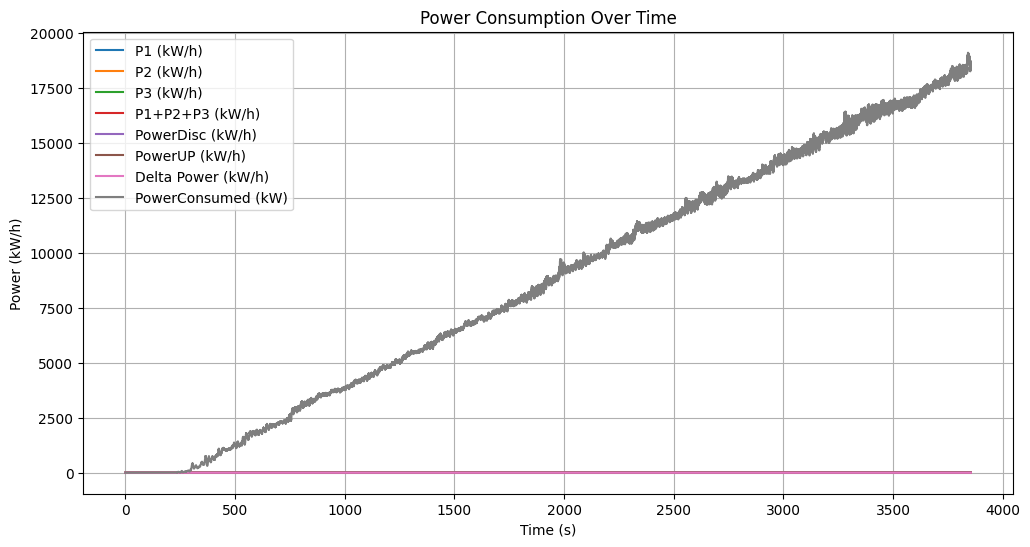

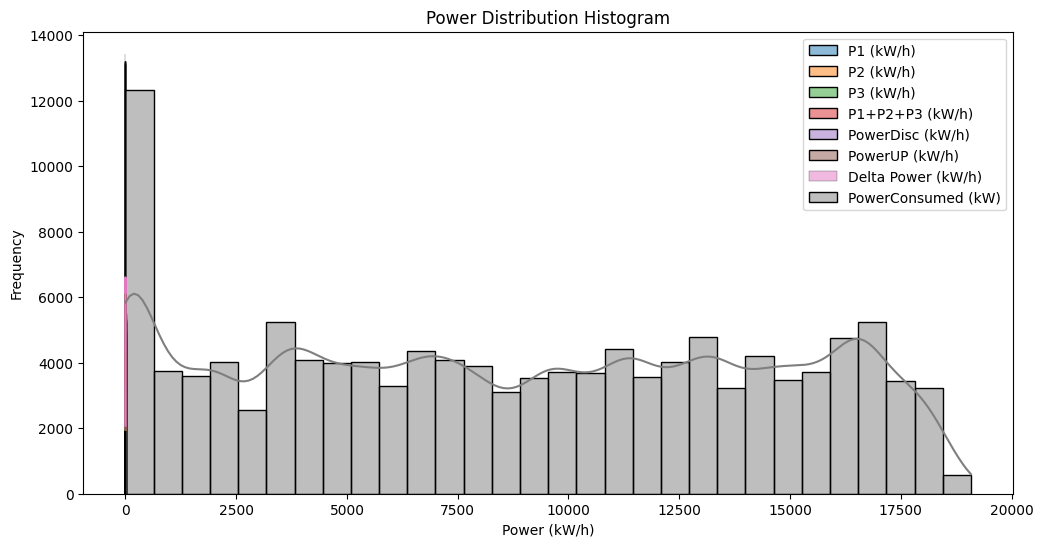

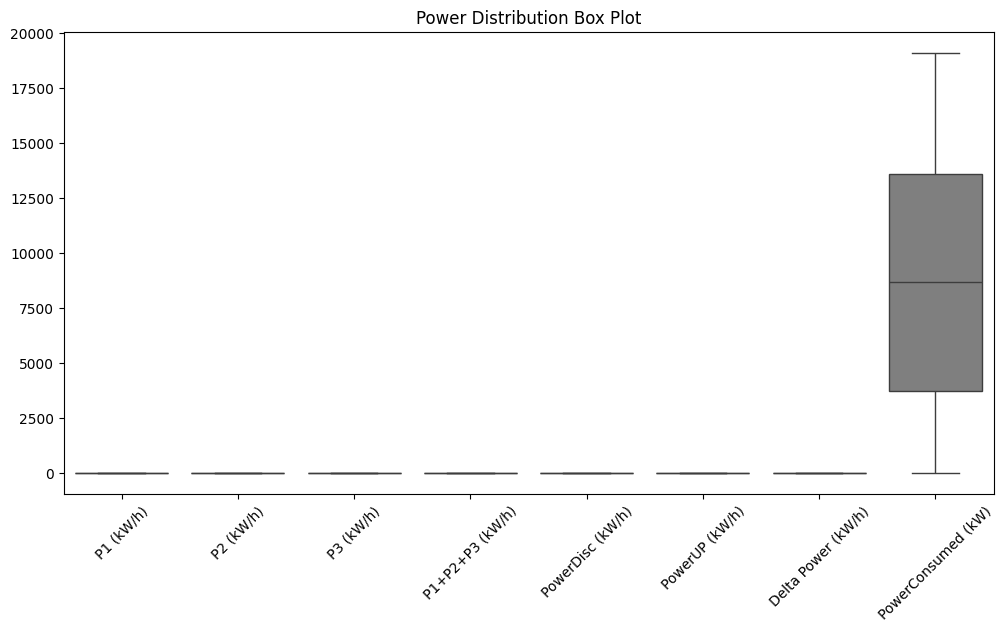

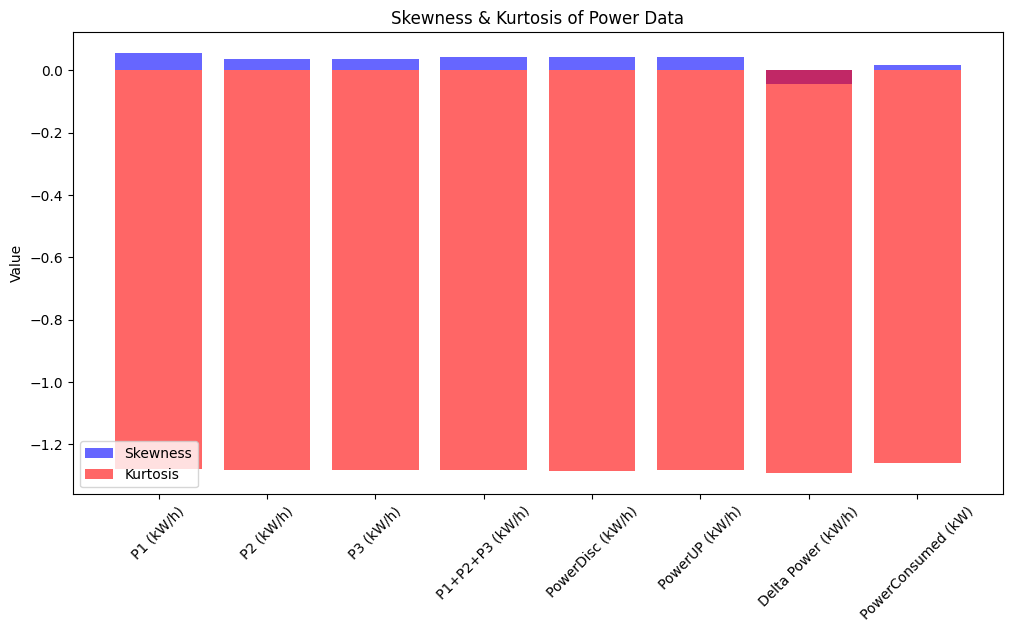

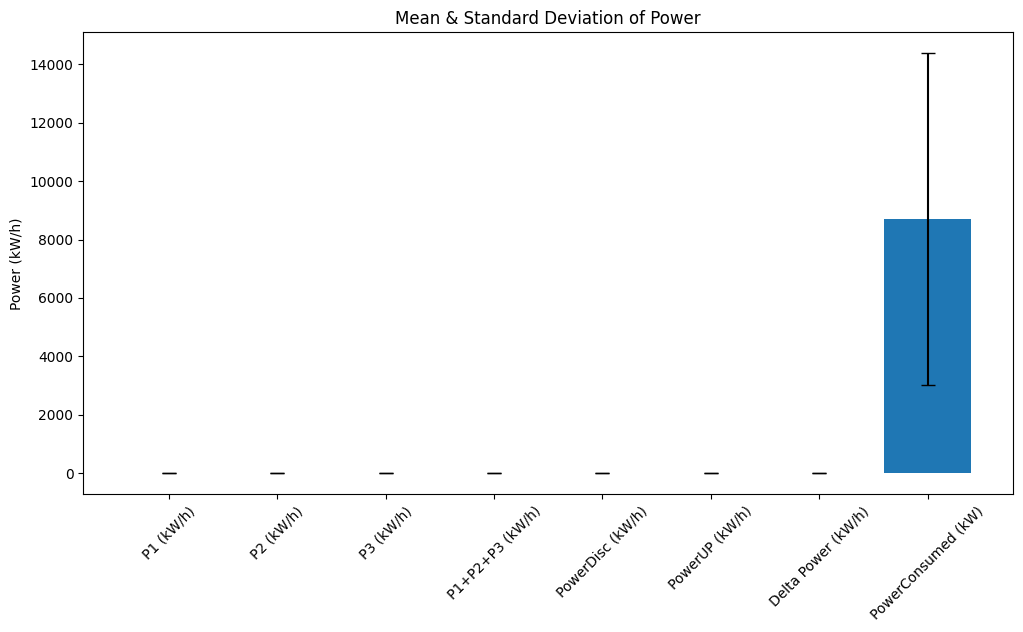

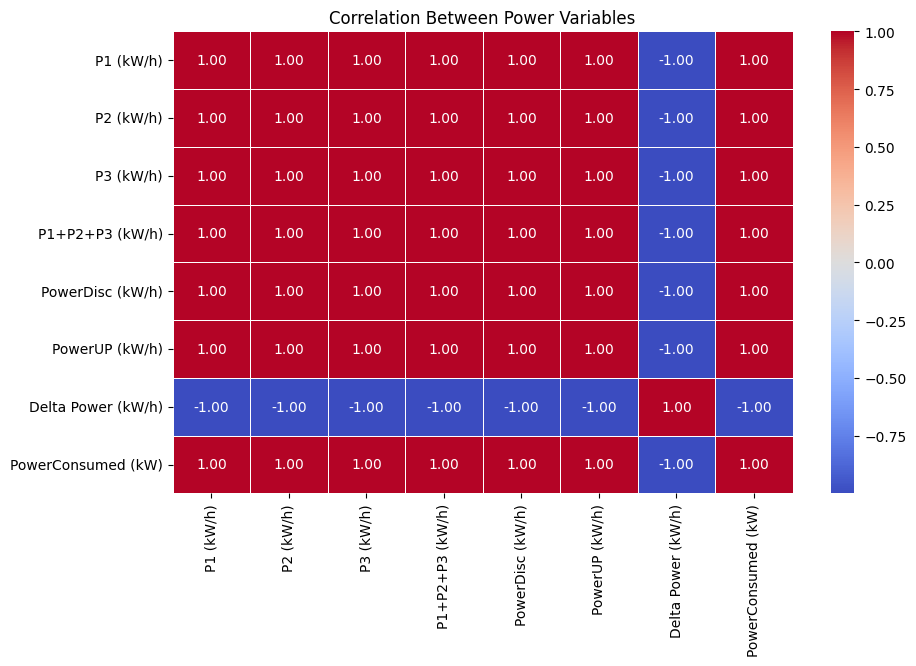

In [ ]:
#5.4 provide graph for mean median and other measurements with correlation (not applicable)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the statistics data
stats_df = pd.read_csv("power_statistics.csv", index_col=0)

time_series_data = pd.read_csv("D:\sprint(main)\python file convertor\convertion\extracted_power_data.csv")

# Convert 'Time (s)' column to numeric, ignore last row if 'Final' exists
time_series_data = time_series_data[time_series_data['Time (s)'] != 'Final']
time_series_data['Time (s)'] = pd.to_numeric(time_series_data['Time (s)'])

power_columns = ['P1 (kW/h)', 'P2 (kW/h)', 'P3 (kW/h)', 'P1+P2+P3 (kW/h)',
                 'PowerDisc (kW/h)', 'PowerUP (kW/h)', 'Delta Power (kW/h)', 'PowerConsumed (kW)']

# --- 1. Line Plot (Power Over Time) ---
plt.figure(figsize=(12, 6))
for col in power_columns:
    plt.plot(time_series_data['Time (s)'], time_series_data[col], label=col)
plt.xlabel("Time (s)")
plt.ylabel("Power (kW/h)")
plt.title("Power Consumption Over Time")
plt.legend()
plt.grid()
plt.show()

# --- 2. Histogram (Power Distribution) ---
plt.figure(figsize=(12, 6))
for col in power_columns:
    sns.histplot(time_series_data[col], kde=True, label=col, bins=30, alpha=0.5)
plt.xlabel("Power (kW/h)")
plt.ylabel("Frequency")
plt.title("Power Distribution Histogram")
plt.legend()
plt.show()

# --- 3. Box Plot (Outlier Analysis) ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=time_series_data[power_columns])
plt.xticks(rotation=45)
plt.title("Power Distribution Box Plot")
plt.show()

# --- 4. Skewness & Kurtosis Distribution ---
plt.figure(figsize=(12, 6))
plt.bar(stats_df.index, stats_df['Skewness'], color='blue', alpha=0.6, label='Skewness')
plt.bar(stats_df.index, stats_df['Kurtosis'], color='red', alpha=0.6, label='Kurtosis')
plt.xticks(rotation=45)
plt.ylabel("Value")
plt.title("Skewness & Kurtosis of Power Data")
plt.legend()
plt.show()

# --- 5. Mean & Standard Deviation Bar Chart ---
plt.figure(figsize=(12, 6))
plt.bar(stats_df.index, stats_df['Mean'], yerr=stats_df['Standard Deviation'], capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Power (kW/h)")
plt.title("Mean & Standard Deviation of Power")
plt.show()

# --- 6. Correlation Heatmap ---
plt.figure(figsize=(10, 6))
corr_matrix = time_series_data[power_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Power Variables")
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3132\2283950543.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Force Applied (N)'].fillna(0, inplace=True)


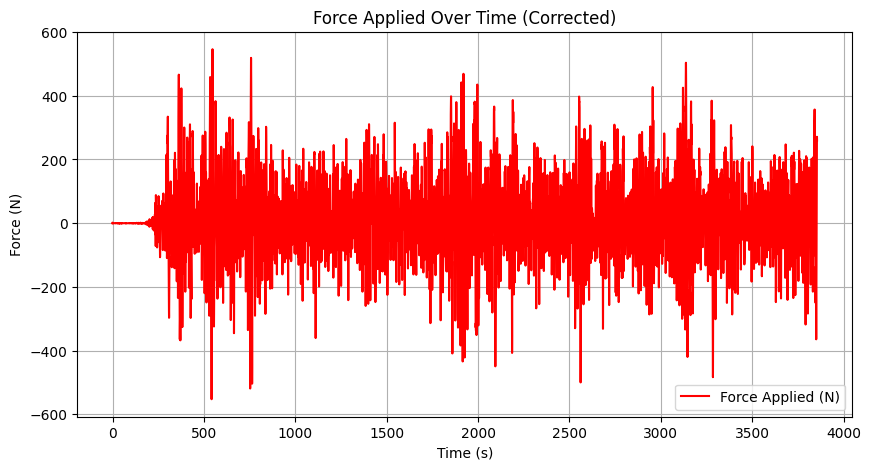

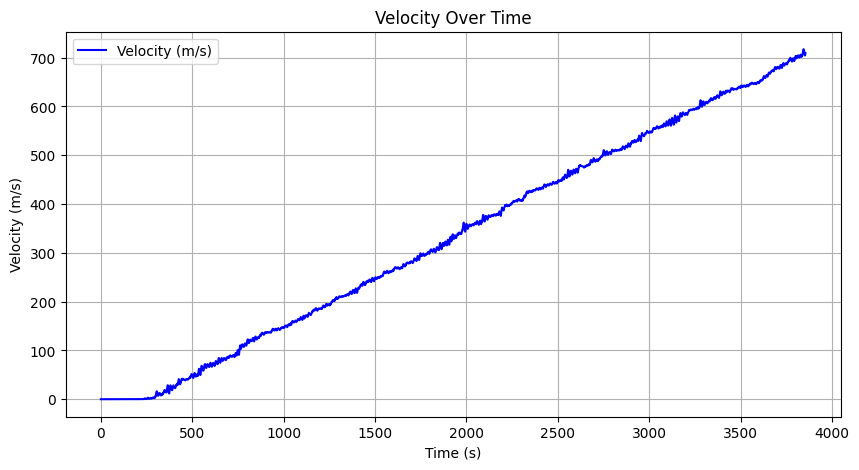

Minimum Force Applied: -552.86 N
Maximum Force Applied: 546.26 N


In [ ]:
#5.5 force vs time and velocity vs time graph.  (not applicable only for force calculation f=m*a where m=116.85)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = r"D:\sprint(main)\python file convertor\convertion\extracted_power_data.csv"
df = pd.read_csv(file_path)

# Ensure 'Time (s)' column is numeric
df = df[df['Time (s)'] != 'Final']
df['Time (s)'] = pd.to_numeric(df['Time (s)'])

# Define inputs from CSV
mass = 116.85  # Mass of the system in kg (Modify if dataset has mass values)
V_initial = df['Velocity'].iloc[0]  # Take initial velocity from first row
time_step = df['Time (s)'].diff().mean()  # Compute average time step
total_time = df['Time (s)'].max()  # Total time duration

# Compute Acceleration (a = dV/dt)
df['Acceleration'] = df['Velocity'].diff() / df['Time (s)'].diff()

# Compute Force (F = m * a)
df['Force Applied (N)'] = mass * df['Acceleration']
#df['Force Applied (N)'] = np.sqrt(df['061T1 (kN)']**2 + df['062T2 (kN)']**2 + df['063T3 (kN)']**2)

# Handle NaN values (first row will have NaN acceleration)
df['Force Applied (N)'].fillna(0, inplace=True)

# Save updated data to a new file
output_file = r"D:\sprint(main)\python file convertor\convertion\updated_output.csv"
df.to_csv(output_file, index=False)

# Generate Time Array
time_values = df['Time (s)']
force_values = df['Force Applied (N)']  # Updated force values
velocity_values = df['Velocity']  # Use actual velocity data

# Plot Force vs. Time
plt.figure(figsize=(10, 5))
plt.plot(time_values, force_values, label='Force Applied (N)', color='r')
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.title("Force Applied Over Time (Corrected)")
plt.legend()
plt.grid()
plt.savefig("graphs/force_vs_time_corrected.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Velocity vs. Time
plt.figure(figsize=(10, 5))
plt.plot(time_values, velocity_values, label='Velocity (m/s)', color='b')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Over Time")
plt.legend()
plt.grid()
plt.savefig("graphs/velocity_vs_time_corrected.png", dpi=300, bbox_inches='tight')
plt.show()

# Print the calculated force range
print(f"Minimum Force Applied: {df['Force Applied (N)'].min():.2f} N")
print(f"Maximum Force Applied: {df['Force Applied (N)'].max():.2f} N")


In [ ]:
#6.1 provide data regarding force,velocity and power with graph (not applicable)
import pandas as pd
import os
import matplotlib.pyplot as plt

# File path (update as needed)
file_path = r'D:\sprint(main)\python file convertor\convertion\extracted_power_data.csv'

# Read CSV with low_memory=False to handle large/mixed-type datasets
df = pd.read_csv(file_path, low_memory=False)

# Ensure necessary directories exist
os.makedirs('convertion/graphs', exist_ok=True)
os.makedirs('convertion/data', exist_ok=True)

# Define column names
time_col = 'Time (s)'
velocity_col = 'Velocity'  # Fixed from 'Velocity (m/s)'
force_col = 'Force'  # Fixed from 'Force Applied (N)'
power_columns = ['510P1 (kW)', '511P2 (kW)', '512P3 (kW)', '513PowerDisc (kW)', '514PowerUP (kW)','PowerConsumed (kW)']

# Check for missing columns
missing_cols = [col for col in [time_col, velocity_col, force_col] + power_columns if col not in df.columns]
if missing_cols:
    print(f"⚠️ Warning: Missing columns in dataset: {missing_cols}")
    print("Exiting script to prevent errors.")
    exit()

# Remove non-numeric rows in time column
df = df[df[time_col].apply(lambda x: str(x).replace('.', '').isdigit())]

# Convert all necessary columns to numeric, replacing errors with NaN
for col in [time_col, velocity_col, force_col] + power_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop NaN rows
df = df.dropna(subset=[time_col, velocity_col, force_col] + power_columns)

# Save cleaned power data
power_df = df[[time_col] + power_columns]
power_csv_path = 'convertion/data/power_data.csv'
power_df.to_csv(power_csv_path, index=False, float_format='%.6f')

# Plot: Power vs Time
plt.figure(figsize=(12, 6))
for column in power_columns:
    plt.plot(df[time_col], df[column], label=column.split(' ')[0], linewidth=1, alpha=0.8)

plt.xlabel('Time (s)')
plt.ylabel('Power (kW)')
plt.title('Power vs Time')
plt.legend()
plt.grid(True)

# Save plot
power_plot_path = 'convertion/graphs/power_vs_time.png'
plt.savefig(power_plot_path, dpi=300, bbox_inches='tight')
plt.close()

# 🆕 Additional Plots

# Plot: Velocity vs Time
plt.figure(figsize=(10, 5))
plt.plot(df[time_col], df[velocity_col], color='blue', label="Velocity (m/s)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Over Time")
plt.legend()
plt.grid(True)
velocity_plot_path = 'convertion/graphs/velocity_vs_time.png'
plt.savefig(velocity_plot_path, dpi=300, bbox_inches='tight')
plt.close()

# Plot: Force vs Time
plt.figure(figsize=(10, 5))
plt.plot(df[time_col], df[force_col], color='red', label="Force Applied (N)")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.title("Force Applied Over Time")
plt.legend()
plt.grid(True)
force_plot_path = 'convertion/graphs/force_vs_time.png'
plt.savefig(force_plot_path, dpi=300, bbox_inches='tight')
plt.close()

# Scatter Plot: Force vs Velocity
plt.figure(figsize=(10, 5))
plt.scatter(df[velocity_col], df[force_col], color='purple', s=5, alpha=0.5, label="Force vs. Velocity")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Force (N)")
plt.title("Force vs. Velocity")
plt.legend()
plt.grid(True)
force_velocity_plot_path = 'convertion/graphs/force_vs_velocity.png'
plt.savefig(force_velocity_plot_path, dpi=300, bbox_inches='tight')
plt.close()

# Print confirmations
print(f"✅ Power data saved to: {power_csv_path}")
print(f"✅ Power vs Time plot saved to: {power_plot_path}")
print(f"✅ Velocity vs Time plot saved to: {velocity_plot_path}")
print(f"✅ Force vs Time plot saved to: {force_plot_path}")
print(f"✅ Force vs Velocity scatter plot saved to: {force_velocity_plot_path}")

# Print first few rows to verify
print("\nFirst few rows of the cleaned data:")
print(df[[time_col, velocity_col, force_col] + power_columns].head())

# Print data info
print("\nData Info:")
print(df[[time_col, velocity_col, force_col] + power_columns].info())


✅ Power data saved to: convertion/data/power_data.csv
✅ Power vs Time plot saved to: convertion/graphs/power_vs_time.png
✅ Velocity vs Time plot saved to: convertion/graphs/velocity_vs_time.png
✅ Force vs Time plot saved to: convertion/graphs/force_vs_time.png
✅ Force vs Velocity scatter plot saved to: convertion/graphs/force_vs_velocity.png

First few rows of the cleaned data:
   Time (s)  Velocity     Force  510P1 (kW)    511P2 (kW)    512P3 (kW)  \
0  0.000000  0.000538  1.306797    0.000077  8.220259e-09  2.362676e-06   
1  0.031623  0.001007  2.458558    0.000048  3.444606e-06  7.761023e-06   
2  0.063246  0.001407  1.951080    0.000076  3.881741e-06  6.126308e-07   
3  0.094869  0.001740  1.818146    0.000073  9.793652e-06  2.209505e-06   
4  0.126492  0.002009  1.711449    0.000123  1.238789e-05  4.836538e-06   

   513PowerDisc (kW)  514PowerUP (kW)  PowerConsumed (kW)  
0           0.000005         0.000082            0.000703  
1           0.000004         0.000062           

In [ ]:
 #6.2) Minimum force needed to create a relative velocity motion of more than 25%.
import pandas as pd
import os
import matplotlib.pyplot as plt

# Read the CSV file with low_memory=False to handle mixed types
df = pd.read_csv(r'D:\sprint(main)\python file convertor\convertion\extracted_power_data.csv', low_memory=False)

# Create directories if they don't exist
os.makedirs('convertion/graphs', exist_ok=True)
os.makedirs('convertion/data', exist_ok=True)

# Define required columns
power_columns = ['510P1 (kW)', '511P2 (kW)', '512P3 (kW)', '513PowerDisc (kW)', '514PowerUP (kW)', 'PowerConsumed (kW)']
time_col = 'Time (s)'
velocity_col = 'Velocity'
force_col = 'Force'

# Check for missing columns and warn if any are missing
missing_cols = [col for col in [velocity_col, force_col, 'PowerConsumed (kW)'] if col not in df.columns]
if missing_cols:
    print(f"⚠️ Warning: Missing columns - {missing_cols}")

# Remove non-numeric rows in Time column
df = df[df[time_col].apply(lambda x: str(x).replace('.', '', 1).isdigit())]

# Convert relevant columns to numeric (if they exist)
for col in [time_col] + power_columns + [velocity_col, force_col]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop NaN values
df = df.dropna(subset=[time_col] + power_columns)

# Create new dataframe with selected columns
selected_columns = [time_col] + power_columns + [col for col in [velocity_col, force_col] if col in df.columns]
filtered_df = df[selected_columns]

# Save cleaned power data
power_csv_path = 'convertion/data/power_data.csv'
filtered_df.to_csv(power_csv_path, index=False, float_format='%.6f')

# Generate Statistics
stats = filtered_df.describe().transpose()
stats_csv_path = 'convertion/data/data_statistics.csv'
stats.to_csv(stats_csv_path, float_format='%.6f')

# ✅ Calculate Min and Max Power Consumption
if 'PowerConsumed (kW)' in filtered_df.columns:
    min_power = filtered_df['PowerConsumed (kW)'].min()
    max_power = filtered_df['PowerConsumed (kW)'].max()

    # Create a DataFrame to store min/max power values
    min_max_power_df = pd.DataFrame({'Metric': ['Min Power Consumed', 'Max Power Consumed'],
                                     'Power (kW)': [min_power, max_power]})

    # Save the min/max power data
    min_max_power_csv = 'convertion/data/min_max_power.csv'
    min_max_power_df.to_csv(min_max_power_csv, index=False, float_format='%.6f')

    print(f"✅ Min/Max Power data saved to: {min_max_power_csv}")

# Print confirmations
print(f"✅ Cleaned data saved to: {power_csv_path}")
print(f"✅ Statistical summary saved to: {stats_csv_path}")

# Print first few rows for verification
print("\n📌 First few rows of the cleaned data:")
print(filtered_df.head())

print("\n📊 Summary Statistics:")
print(stats)

# 📊 Plot Power vs Time
plt.figure(figsize=(12, 6))
for column in power_columns:
    plt.plot(filtered_df[time_col], filtered_df[column], label=column.split(' ')[0], linewidth=1, alpha=0.8)

plt.xlabel('Time (s)')
plt.ylabel('Power (kW)')
plt.title('Power vs Time')
plt.legend()
plt.grid(True)

# Save Power Plot
plot_path = 'convertion/graphs/power_vs_time.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"📊 Power vs Time graph saved to: {plot_path}")


✅ Min/Max Power data saved to: convertion/data/min_max_power.csv
✅ Cleaned data saved to: convertion/data/power_data.csv
✅ Statistical summary saved to: convertion/data/data_statistics.csv

📌 First few rows of the cleaned data:
   Time (s)  510P1 (kW)    511P2 (kW)    512P3 (kW)  513PowerDisc (kW)  \
0  0.000000    0.000077  8.220259e-09  2.362676e-06           0.000005   
1  0.031623    0.000048  3.444606e-06  7.761023e-06           0.000004   
2  0.063246    0.000076  3.881741e-06  6.126308e-07           0.000002   
3  0.094869    0.000073  9.793652e-06  2.209505e-06           0.000013   
4  0.126492    0.000123  1.238789e-05  4.836538e-06           0.000020   

   514PowerUP (kW)  PowerConsumed (kW)  Velocity     Force  
0         0.000082            0.000703  0.000538  1.306797  
1         0.000062            0.002475  0.001007  2.458558  
2         0.000044            0.002744  0.001407  1.951080  
3         0.000096            0.003163  0.001740  1.818146  
4         0.000180    

In [ ]:
#   Your force calculation only uses mooring tensions (T1, T2, T3).
#   Fix: Check if buoy or disc forces (Fx_Up, Fz_Disc, etc.) exist in the dataset.
#   Approach: Compare mooring forces vs. buoy/disc forces. If buoy/disc forces contribute significantly, update the force calculation? 

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22856\3021841086.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date_Time"] = pd.to_datetime(df.iloc[:, 0] + " " + df.iloc[:, 1], errors='coerce')


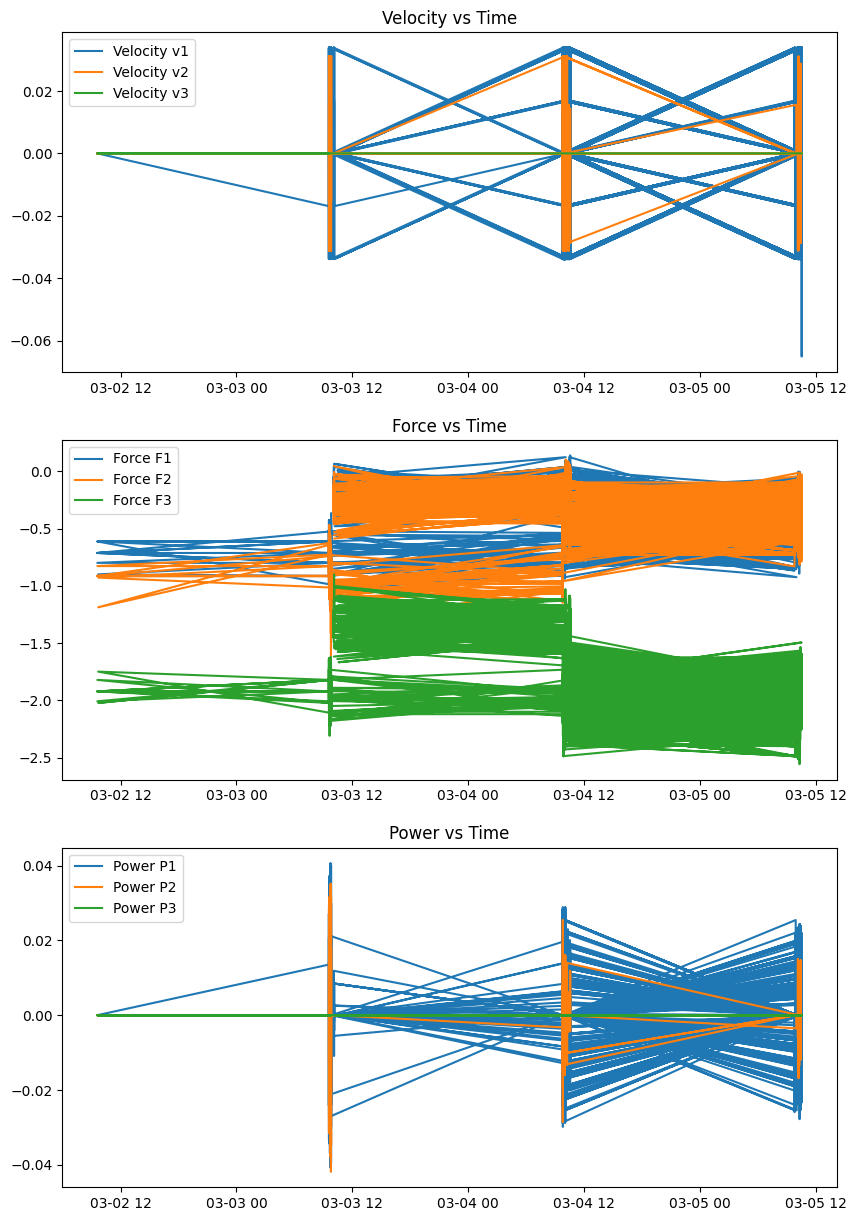

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load CSV Data
file_path = r"D:\sprint(main)\python file convertor\Project Info\230927\2023-09-27_9h_34m_54s_PTO__MRU_8Hz.CSV"  # Use raw string to avoid escape errors
df = pd.read_csv(file_path, dtype=str)  # Read all as strings initially

# Parse Date and Time columns properly
df["Date_Time"] = pd.to_datetime(df.iloc[:, 0] + " " + df.iloc[:, 1], errors='coerce')
df.set_index("Date_Time", inplace=True)

# Convert all numeric columns to float (handling errors)
numeric_cols = ["Zla1(mm)", "Zla2(mm)", "Zla3(mm)", "PT1(Bar)", "PT2(Bar)", "PT3(Bar)", "PT4(Bar)", 
                "PT5(Bar)", "PT6(Bar)", "PT7(Bar)", "PT8(Bar)", "PT9(Bar)", "PT10(Bar)", "PT11(Bar)", "PT12(Bar)"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Piston and Rod Dimensions
PISTON_HEAD_DIAMETER = 80.0e-3  # Convert mm to meters
PISTON_ROD_DIAMETER = 30.0e-3   # Convert mm to meters

# Compute Areas
head_area = np.pi * (PISTON_HEAD_DIAMETER ** 2) / 4
rod_area = np.pi * (PISTON_ROD_DIAMETER ** 2) / 4

# Compute Velocities
df['Time_Diff'] = df.index.to_series().diff().dt.total_seconds()
df["v1 (m/s)"] = 1e-3 * df["Zla1(mm)"].diff() / df['Time_Diff']
df["v2 (m/s)"] = 1e-3 * df["Zla2(mm)"].diff() / df['Time_Diff']
df["v3 (m/s)"] = 1e-3 * df["Zla3(mm)"].diff() / df['Time_Diff']

# Compute Forces
df["F1 (kN)"] = 100 * ((head_area - rod_area) * (df["PT6(Bar)"] + df["PT8(Bar)"]) - head_area * (df["PT5(Bar)"] + df["PT7(Bar)"]))
df["F2 (kN)"] = 100 * ((head_area - rod_area) * (df["PT2(Bar)"] + df["PT4(Bar)"]) - head_area * (df["PT1(Bar)"] + df["PT3(Bar)"]))
df["F3 (kN)"] = 100 * ((head_area - rod_area) * (df["PT10(Bar)"] + df["PT12(Bar)"]) - head_area * (df["PT9(Bar)"] + df["PT11(Bar)"]))

# Compute Power
df["P1 (kW)"] = df["F1 (kN)"] * df["v1 (m/s)"]
df["P2 (kW)"] = df["F2 (kN)"] * df["v2 (m/s)"]
df["P3 (kW)"] = df["F3 (kN)"] * df["v3 (m/s)"]

# Compute Cumulative Energy
df['Delta_t_hours'] = df['Time_Diff'] / 3600  # Convert seconds to hours
df["Energy (kWh)"] = (df["P1 (kW)"] + df["P2 (kW)"] + df["P3 (kW)"]).cumsum() * df['Delta_t_hours']

# Plot Graphs
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].plot(df.index, df["v1 (m/s)"], label="Velocity v1")
ax[0].plot(df.index, df["v2 (m/s)"], label="Velocity v2")
ax[0].plot(df.index, df["v3 (m/s)"], label="Velocity v3")
ax[0].set_title("Velocity vs Time")
ax[0].legend()

ax[1].plot(df.index, df["F1 (kN)"], label="Force F1")
ax[1].plot(df.index, df["F2 (kN)"], label="Force F2")
ax[1].plot(df.index, df["F3 (kN)"], label="Force F3")
ax[1].set_title("Force vs Time")
ax[1].legend()

ax[2].plot(df.index, df["P1 (kW)"], label="Power P1")
ax[2].plot(df.index, df["P2 (kW)"], label="Power P2")
ax[2].plot(df.index, df["P3 (kW)"], label="Power P3")
ax[2].set_title("Power vs Time")
ax[2].legend()

plt.show()

# Save processed data
df.to_csv("processed_output.csv")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22856\2904637889.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date_Time"] = pd.to_datetime(df.iloc[:, 0] + " " + df.iloc[:, 1], errors='coerce')


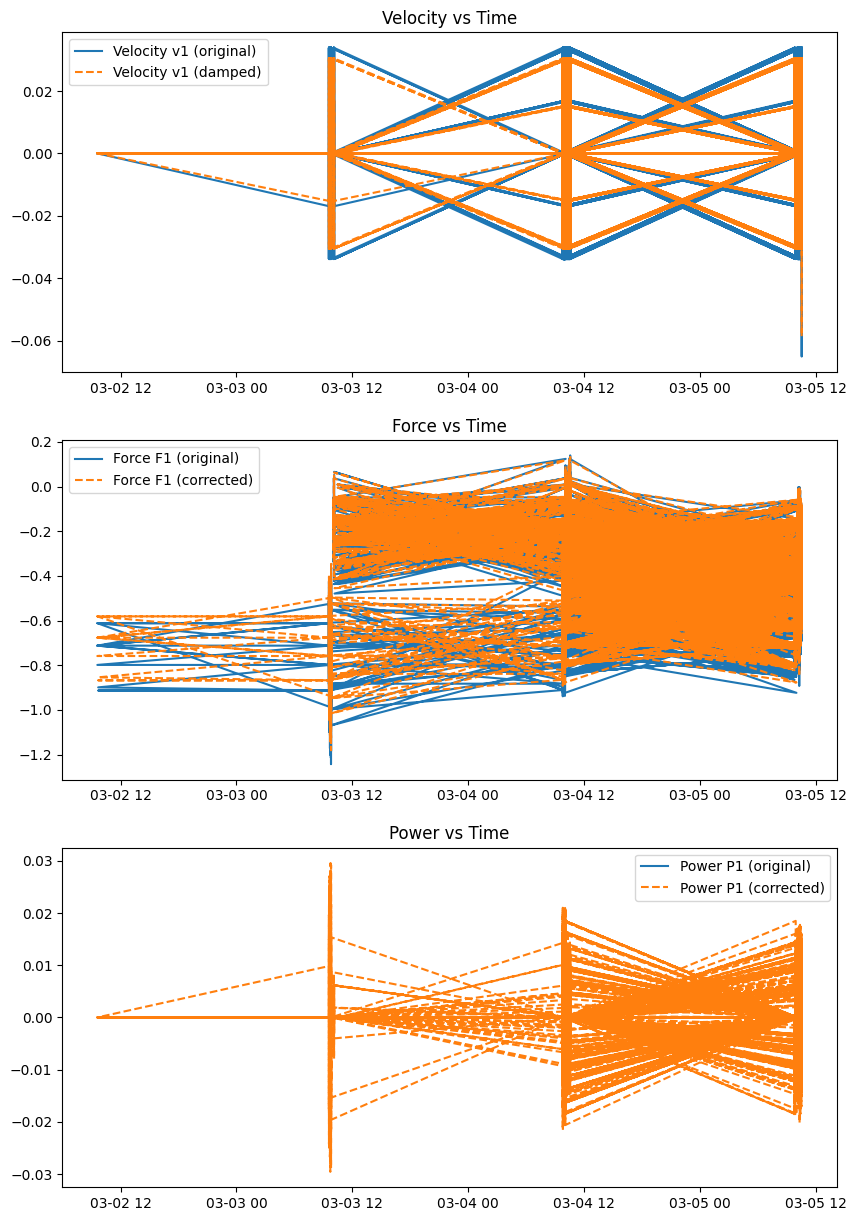

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load CSV Data
file_path = r"D:\sprint(main)\python file convertor\Project Info\230927\2023-09-27_9h_34m_54s_PTO__MRU_8Hz.CSV"
df = pd.read_csv(file_path, dtype=str)

# Parse Date and Time columns properly
df["Date_Time"] = pd.to_datetime(df.iloc[:, 0] + " " + df.iloc[:, 1], errors='coerce')
df.set_index("Date_Time", inplace=True)

# Convert all numeric columns to float
numeric_cols = ["Zla1(mm)", "Zla2(mm)", "Zla3(mm)", "PT1(Bar)", "PT2(Bar)", "PT3(Bar)", "PT4(Bar)", 
                "PT5(Bar)", "PT6(Bar)", "PT7(Bar)", "PT8(Bar)", "PT9(Bar)", "PT10(Bar)", "PT11(Bar)", "PT12(Bar)"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Piston and Rod Dimensions
PISTON_HEAD_DIAMETER = 80.0e-3  # Convert mm to meters
PISTON_ROD_DIAMETER = 30.0e-3   # Convert mm to meters

# Compute Areas
head_area = np.pi * (PISTON_HEAD_DIAMETER ** 2) / 4
rod_area = np.pi * (PISTON_ROD_DIAMETER ** 2) / 4

# Compute Velocities
df['Time_Diff'] = df.index.to_series().diff().dt.total_seconds()
df["v1 (m/s)"] = 1e-3 * df["Zla1(mm)"].diff() / df['Time_Diff']
df["v2 (m/s)"] = 1e-3 * df["Zla2(mm)"].diff() / df['Time_Diff']
df["v3 (m/s)"] = 1e-3 * df["Zla3(mm)"].diff() / df['Time_Diff']

# Compute Forces
df["F1 (kN)"] = 100 * ((head_area - rod_area) * (df["PT6(Bar)"] + df["PT8(Bar)"]) - head_area * (df["PT5(Bar)"] + df["PT7(Bar)"]))
df["F2 (kN)"] = 100 * ((head_area - rod_area) * (df["PT2(Bar)"] + df["PT4(Bar)"]) - head_area * (df["PT1(Bar)"] + df["PT3(Bar)"]))
df["F3 (kN)"] = 100 * ((head_area - rod_area) * (df["PT10(Bar)"] + df["PT12(Bar)"]) - head_area * (df["PT9(Bar)"] + df["PT11(Bar)"]))

# Introduce Additional Factors
friction_coefficient = 0.05  # Assume 5% force loss due to friction
damping_coefficient = 0.1    # Assume small damping effect
efficiency = 0.85            # Assume 85% energy conversion efficiency

# Apply corrections
df["F1_corrected (kN)"] = df["F1 (kN)"] * (1 - friction_coefficient)
df["F2_corrected (kN)"] = df["F2 (kN)"] * (1 - friction_coefficient)
df["F3_corrected (kN)"] = df["F3 (kN)"] * (1 - friction_coefficient)

df["v1_damped (m/s)"] = df["v1 (m/s)"] - damping_coefficient * df["v1 (m/s)"]
df["v2_damped (m/s)"] = df["v2 (m/s)"] - damping_coefficient * df["v2 (m/s)"]
df["v3_damped (m/s)"] = df["v3 (m/s)"] - damping_coefficient * df["v3 (m/s)"]

# Compute Corrected Power
df["P1_corrected (kW)"] = df["F1_corrected (kN)"] * df["v1_damped (m/s)"] * efficiency
df["P2_corrected (kW)"] = df["F2_corrected (kN)"] * df["v2_damped (m/s)"] * efficiency
df["P3_corrected (kW)"] = df["F3_corrected (kN)"] * df["v3_damped (m/s)"] * efficiency

# Compute Cumulative Energy
df['Delta_t_hours'] = df['Time_Diff'] / 3600
df["Energy_corrected (kWh)"] = (df["P1_corrected (kW)"] + df["P2_corrected (kW)"] + df["P3_corrected (kW)"]).cumsum() * df['Delta_t_hours']

# Plot Graphs
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].plot(df.index, df["v1 (m/s)"], label="Velocity v1 (original)")
ax[0].plot(df.index, df["v1_damped (m/s)"], label="Velocity v1 (damped)", linestyle='dashed')
ax[0].set_title("Velocity vs Time")
ax[0].legend()

ax[1].plot(df.index, df["F1 (kN)"], label="Force F1 (original)")
ax[1].plot(df.index, df["F1_corrected (kN)"], label="Force F1 (corrected)", linestyle='dashed')
ax[1].set_title("Force vs Time")
ax[1].legend()

ax[2].plot(df.index, df.get("P1 (kW)", pd.Series([np.nan] * len(df))), label="Power P1 (original)")
ax[2].plot(df.index, df["P1_corrected (kW)"], label="Power P1 (corrected)", linestyle='dashed')
ax[2].set_title("Power vs Time")
ax[2].legend()

plt.show()

# Save processed data
df.to_csv("processed_output_corrected.csv")
